In [3]:
# まずは全てインポート
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.accounts import AccountNotFoundError
from qc_workbook.show_state import statevector_expr
from qc_workbook.optimized_additions import optimized_additions
from qc_workbook.utils import operational_backend, find_best_chain

print('notebook ready')

notebook ready


量子フーリエ変換

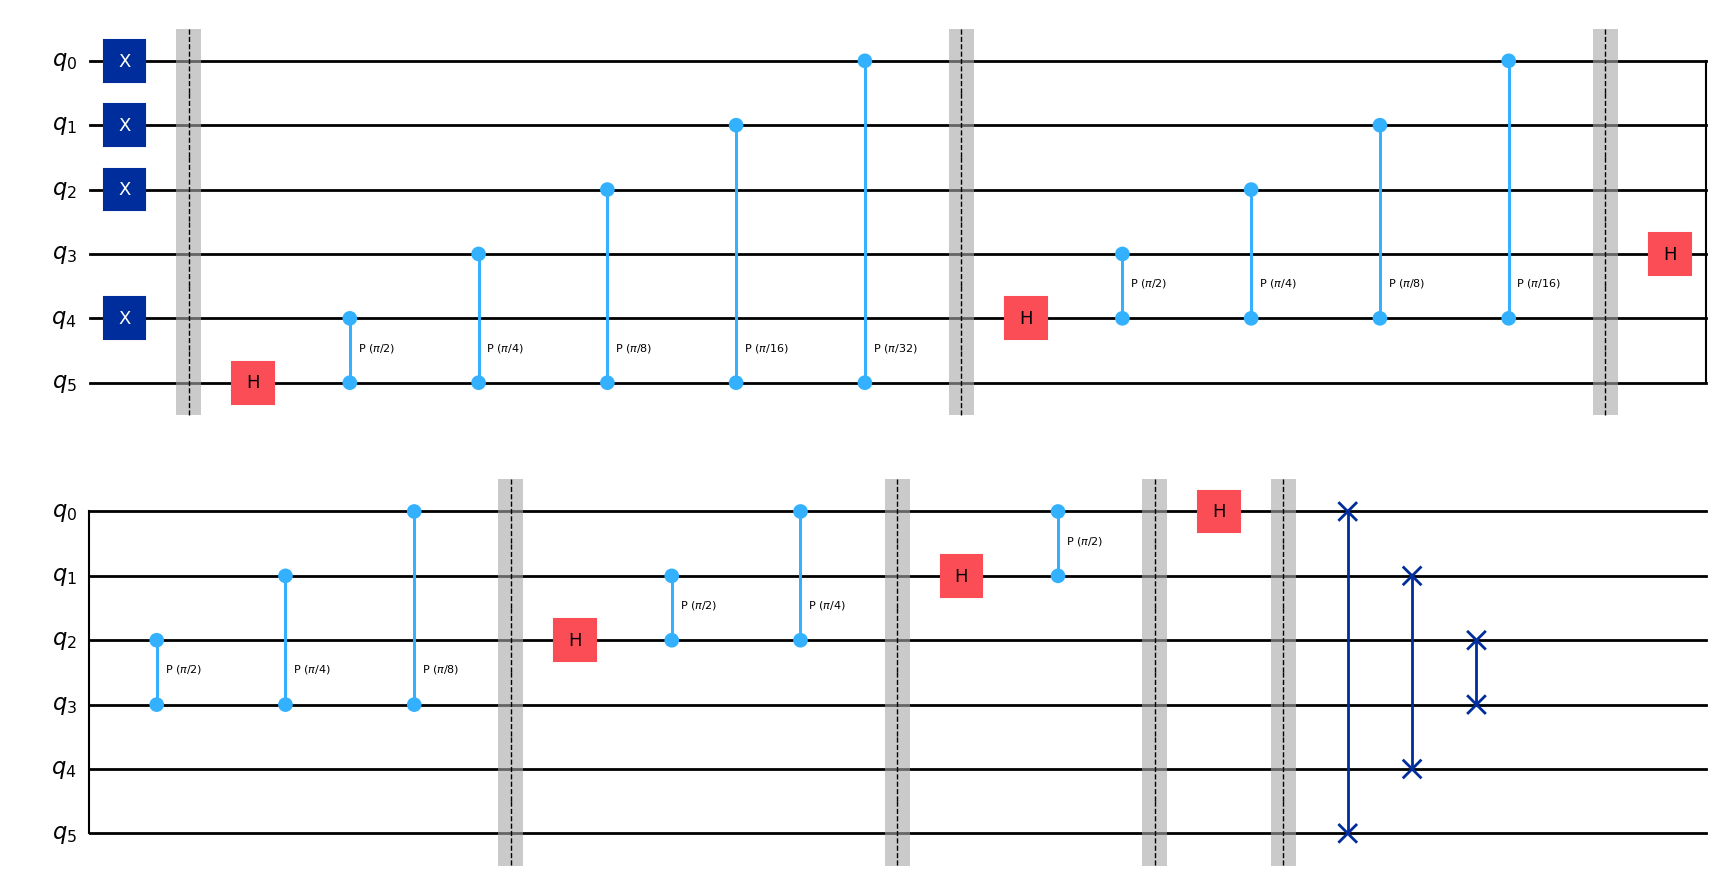

In [4]:
num_qubits = 6

circuit = QuantumCircuit(num_qubits)

# 具体的にするため、入力状態を|23>とする
j = 23

## jの２進数表現で値が1になっているビットに対してXを作用させる -> 状態|j>を作る

# まずjの２進数表現を得るために、unpackbitsを利用（他にもいろいろな方法がある）
# unpackbitsはuint8タイプのアレイを引数に取るので、jをその形に変換してから渡している
j_bits = np.unpackbits(np.asarray(j, dtype=np.uint8), bitorder='little')
# 次にj_bitsアレイのうち、ビットが立っているインデックスを得る
j_indices = np.nonzero(j_bits)[0]
# 最後にcircuit.x()
for idx in j_indices:
    circuit.x(idx)

## Alternative method
#for i in range(num_qubits):
#    if ((j >> i) & 1) == 1:
#        circuit.x(i)

circuit.barrier()

## ここからがQFT

# n-1から0まで標的ビットについてループ
for itarg in range(num_qubits - 1, -1, -1):
    # 標的ビットにアダマールゲートをかける
    circuit.h(itarg)
    # target - 1から0まで制御ビットについてループ
    for ictrl in range(itarg - 1, -1, -1):
        # 標的と制御ビットのインデックスに応じた角度で制御Pゲートをかける
        power = ictrl - itarg - 1 + num_qubits
        circuit.cp((2 ** power) * 2. * np.pi / (2 ** num_qubits), ictrl, itarg)

    # 回路図を見やすくするためにバリアを入れる
    circuit.barrier()

# 最後にビットの順番を反転させる
for i in range(num_qubits // 2):
    circuit.swap(i, num_qubits - 1 - i)

## ここまでがQFT

circuit.draw('mpl')

In [5]:
sqrt_2_to_n = 2 ** (num_qubits // 2)
amp_norm = (1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n)
phase_norm = (2 * np.pi / (2 ** num_qubits), r'\frac{2 \pi i}{%d}' % (2 ** num_qubits))
expr = statevector_expr(circuit, amp_norm=amp_norm, phase_norm=phase_norm)
Math(expr)

<IPython.core.display.Math object>

量子フーリエ変換による足し算

In [6]:
def setup_addition(circuit, reg1, reg2, reg3):
    # reg3にequal superpositionを生成
    # QuantumCircuitの1量子ビットゲートに対応するメソッド（circuit.hなど）に単一の量子ビットの代わりに
    # レジスタや量子ビットのリストを渡すと、含まれる全ての量子ビットに同じゲートをかけてくれる
    circuit.h(reg3)

    # 位相の単位（dphiの整数倍の位相をCPゲートでかけていく）
    dphi = 2. * np.pi / (2 ** reg3.size)

    # reg1とreg2それぞれの量子ビットで制御する
    for reg_ctrl in [reg1, reg2]:
        # 制御ビットに関するループ
        for ictrl, qctrl in enumerate(reg_ctrl):
            # reg3の標的ビットに関するループ
            for itarg, qtarg in enumerate(reg3):
                # C[P(phi)], phi = 2pi * 2^{ictrl} * 2^{itarg} / 2^{n3}
                circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)

    # 回路図を見やすくするためのバリア
    circuit.barrier()

    # Inverse QFT
    for j in range(reg3.size // 2):
        circuit.swap(reg3[j], reg3[-1 - j])

    for itarg in range(reg3.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1 + reg3.size
            circuit.cp(-dphi * (2 ** power), reg3[ictrl], reg3[itarg])

        circuit.h(reg3[itarg])

print('Defined function setup_addition')

Defined function setup_addition


n1=4, n2=4, n3=5


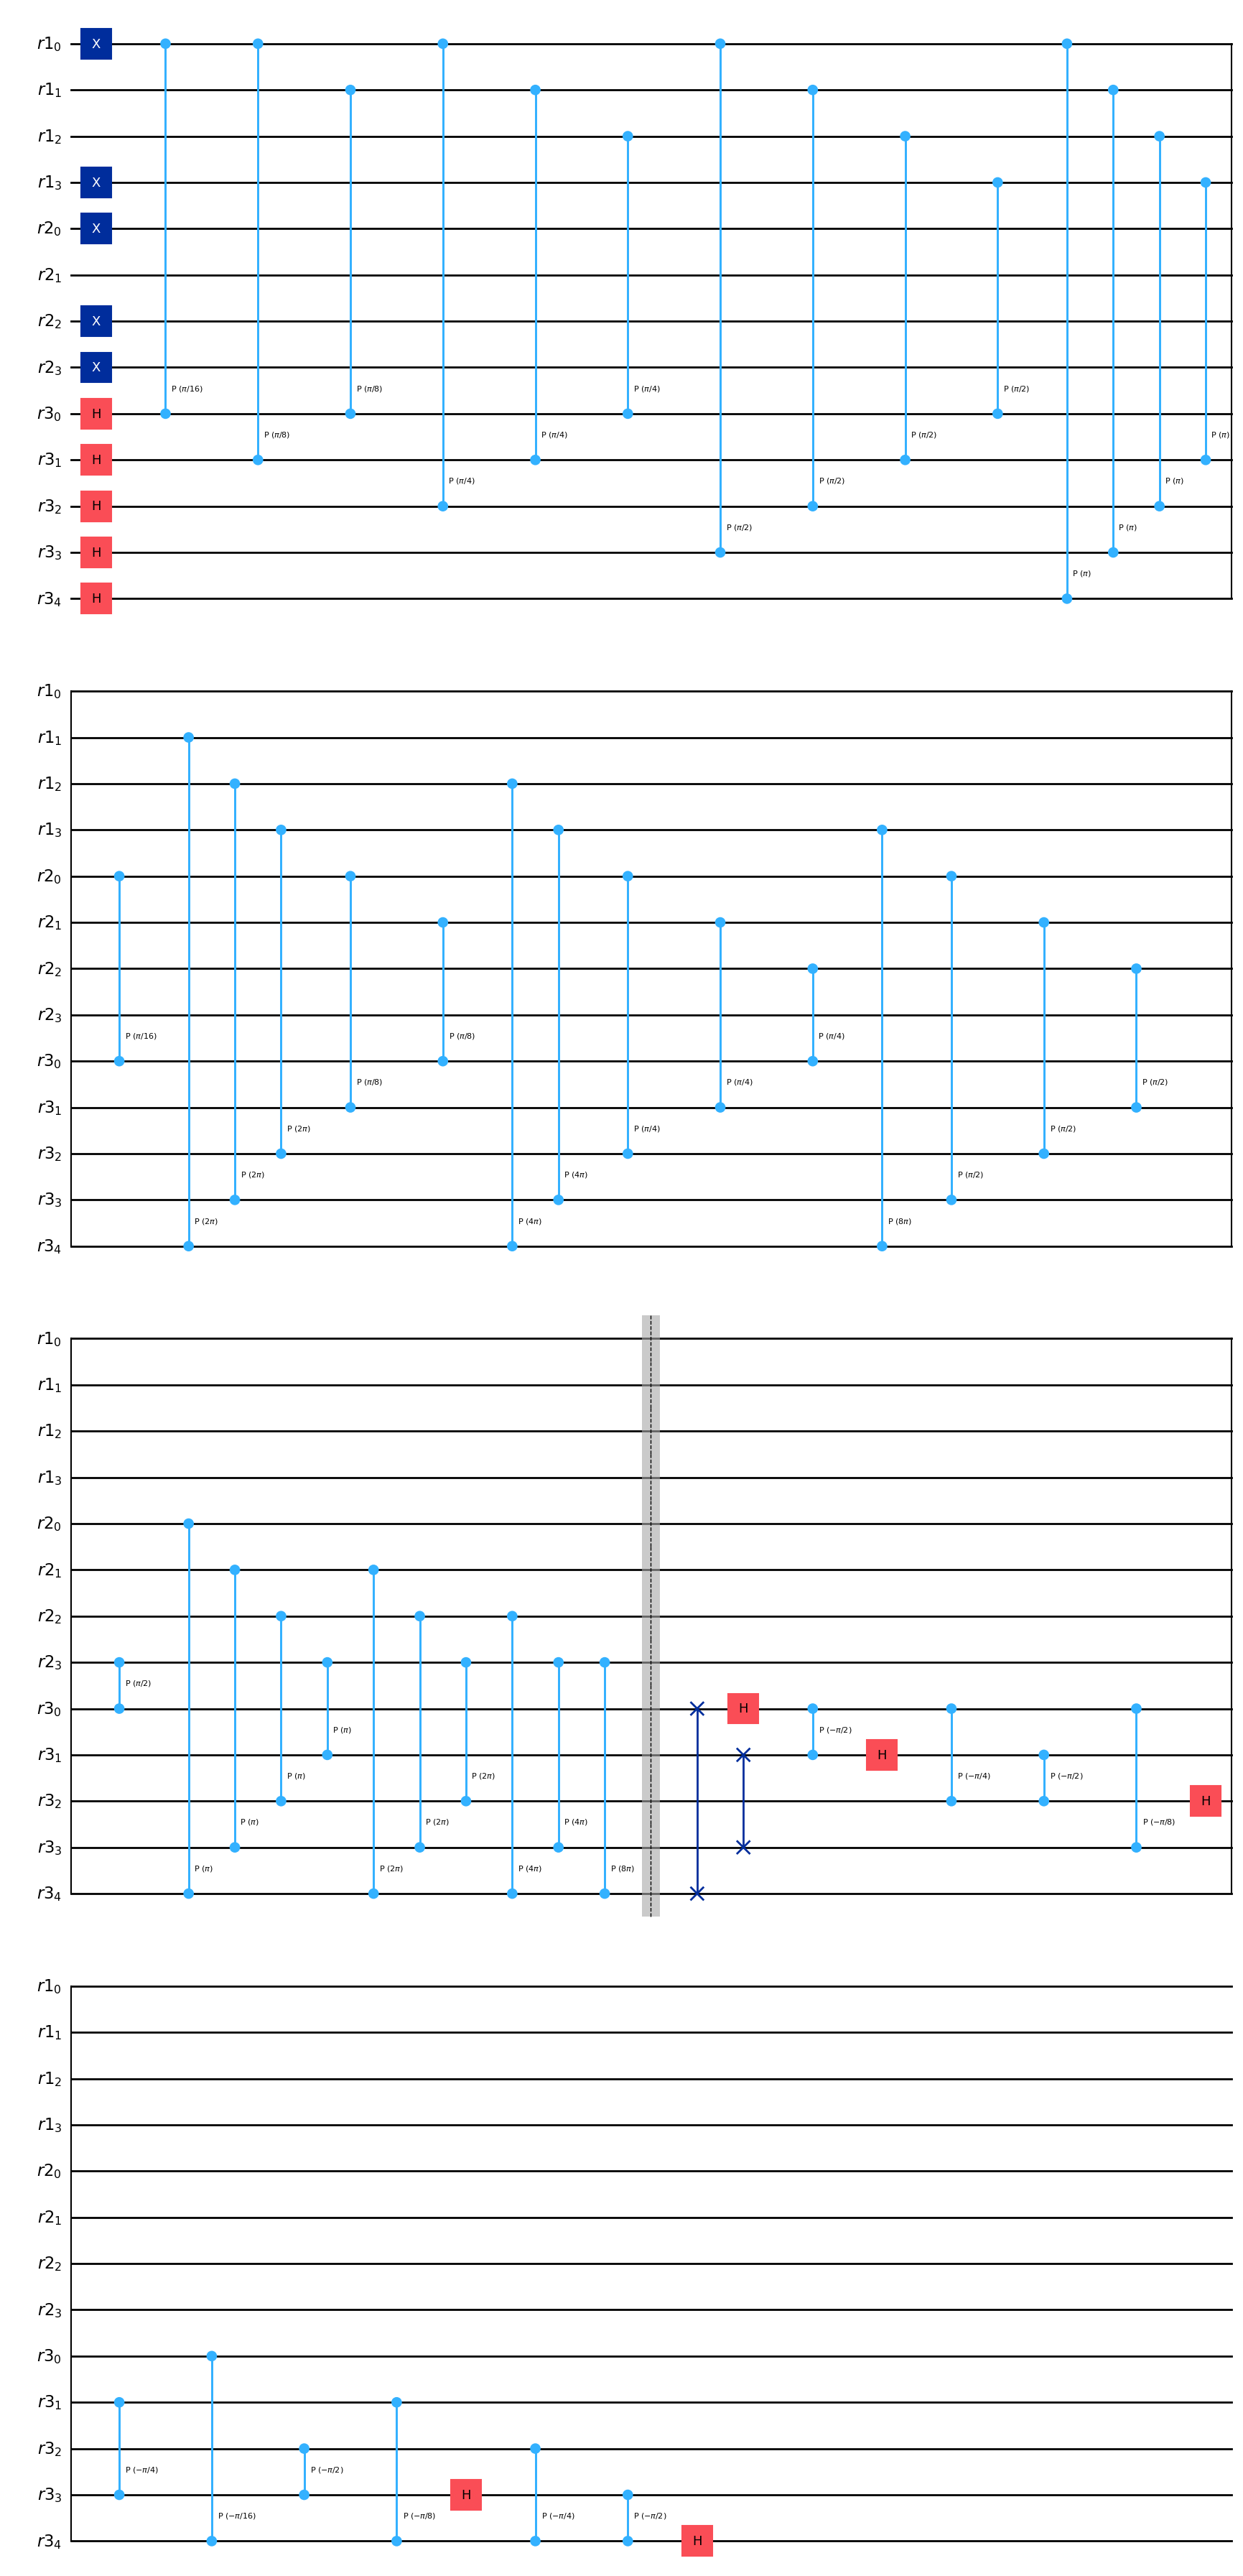

In [7]:
a = 9
b = 13

# 入力の値を二進数表現できる最小のビット数を計算
n1 = np.ceil(np.log2(a + 1)).astype(int)
n2 = np.ceil(np.log2(b + 1)).astype(int)
n3 = np.ceil(np.log2(a + b + 1)).astype(int)

print(f'n1={n1}, n2={n2}, n3={n3}')

reg1 = QuantumRegister(n1, 'r1')
reg2 = QuantumRegister(n2, 'r2')
reg3 = QuantumRegister(n3, 'r3')

# QuantumCircuitは量子ビット数の代わりにレジスタを渡しても作成できる
circuit = QuantumCircuit(reg1, reg2, reg3)

# reg1を|a>にする
a_bits = np.unpackbits(np.asarray(a, dtype=np.uint8), bitorder='little')
for idx in np.nonzero(a_bits)[0]:
    circuit.x(reg1[idx])

# reg2を|b>にする
b_bits = np.unpackbits(np.asarray(b, dtype=np.uint8), bitorder='little')
for idx in np.nonzero(b_bits)[0]:
    circuit.x(reg2[idx])

# 足し算ルーチンを呼ぶ
setup_addition(circuit, reg1, reg2, reg3)

# 回路図を確認
circuit.draw('mpl')

In [8]:
expr = statevector_expr(circuit, register_sizes=(n1, n2, n3))
Math(expr)

<IPython.core.display.Math object>

足し算の並列化


In [9]:
n1 = 4
n2 = 4
n3 = np.ceil(np.log2((2 ** n1) + (2 ** n2) - 1)).astype(int)

reg1 = QuantumRegister(n1, 'r1')
reg2 = QuantumRegister(n2, 'r2')
reg3 = QuantumRegister(n3, 'r3')

circuit = QuantumCircuit(reg1, reg2, reg3)

# reg1とreg2をequal superpositionにする
circuit.h(reg1)
circuit.h(reg2)

setup_addition(circuit, reg1, reg2, reg3)

expr = statevector_expr(circuit, register_sizes=(n1, n2, n3), amp_norm=(1. / np.sqrt(2 ** (n1 + n2)), r'\frac{1}{\sqrt{2^{n_1 + n_2}}}'))
Math(expr)

<IPython.core.display.Math object>

シミュレータでの実行

実機

In [ ]:
# まずは全てインポート
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime.accounts import AccountNotFoundError
from qc_workbook.optimized_additions import optimized_additions
from qc_workbook.utils import operational_backend, find_best_chain

print('notebook ready')

notebook ready


In [13]:
# 利用できるインスタンスが複数ある場合（Premium accessなど）はここで指定する
# instance = 'hub-x/group-y/project-z'
instance = None

try:
    service = QiskitRuntimeService(channel='ibm_quantum', instance=instance)
except AccountNotFoundError:
    service = QiskitRuntimeService(channel='ibm_quantum', token='5086e1c440a84e2a66e645089c18f33ebdd628ac30319351e54d4cd4a8336cb044acd98b4d8b994613a44c4f3017889a54bec1eb03c01baca9fb12b7e0d99790', instance=instance)

backend = service.least_busy(min_num_qubits=13, filters=operational_backend())

print(f'Using backend {backend.name}')

Using backend ibm_brisbane


In [14]:
def setup_addition(circuit, reg1, reg2, reg3):
    """Set up an addition subroutine to a circuit with three registers
    """

    # Equal superposition in register 3
    circuit.h(reg3)

    # Smallest unit of phi
    dphi = 2. * np.pi / (2 ** reg3.size)

    # Loop over reg1 and reg2
    for reg_ctrl in [reg1, reg2]:
        # Loop over qubits in the control register (reg1 or reg2)
        for ictrl, qctrl in enumerate(reg_ctrl):
            # Loop over qubits in the target register (reg3)
            for itarg, qtarg in enumerate(reg3):
                # C[P(phi)], phi = 2pi * 2^{ictrl} * 2^{itarg} / 2^{n3}
                circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)

    # Insert a barrier for better visualization
    circuit.barrier()

    # Inverse QFT
    for j in range(reg3.size // 2):
        circuit.swap(reg3[j], reg3[-1 - j])

    for itarg in range(reg3.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1 + reg3.size
            circuit.cp(-dphi * (2 ** power), reg3[ictrl], reg3[itarg])

        circuit.h(reg3[itarg])

def make_original_circuit(n1, n2):
    """A function to define a circuit with the original implementation of additions given n1 and n2
    """
    n3 = np.ceil(np.log2((2 ** n1) + (2 ** n2) - 1)).astype(int)

    reg1 = QuantumRegister(n1, 'r1')
    reg2 = QuantumRegister(n2, 'r2')
    reg3 = QuantumRegister(n3, 'r3')

    # QuantumCircuit can be instantiated from multiple registers
    circuit = QuantumCircuit(reg1, reg2, reg3)

    # Set register 1 and 2 to equal superpositions
    circuit.h(reg1)
    circuit.h(reg2)

    setup_addition(circuit, reg1, reg2, reg3)

    circuit.measure_all()

    return circuit

In [15]:
# count_ops()の結果をテキストにする関数
def display_nops(circuit):
    nops = circuit.count_ops()
    text = []
    for key in ['rz', 'x', 'sx', 'cx']:
        text.append(f'N({key})={nops.get(key, 0)}')

    return ', '.join(text)

# オリジナルと効率化した回路を作る関数
def make_circuits(n1, n2, backend):
    print(f'Original circuit with n1, n2 = {n1}, {n2}')
    circuit_orig = make_original_circuit(n1, n2)

    print('  Transpiling..')
    circuit_orig = transpile(circuit_orig, backend=backend, optimization_level=3)

    print(f'  Done. Ops: {display_nops(circuit_orig)}')
    circuit_orig.name = f'original_{n1}_{n2}'

    print(f'Optimized circuit with n1, n2 = {n1}, {n2}')
    circuit_opt = optimized_additions(n1, n2)

    n3 = np.ceil(np.log2((2 ** n1) + (2 ** n2) - 1)).astype(int)

    print('  Transpiling..')
    initial_layout = find_best_chain(backend, n1 + n2 + n3)
    circuit_opt = transpile(circuit_opt, backend=backend, routing_method='basic',
                            initial_layout=initial_layout, optimization_level=3)

    print(f'  Done. Ops: {display_nops(circuit_opt)}')
    circuit_opt.name = f'optimized_{n1}_{n2}'

    return [circuit_orig, circuit_opt]

In [17]:
# List of circuits
circuits = []
for n1, n2 in [(4, 4), (3, 3), (2, 2), (1, 1)]:
    circuits += make_circuits(n1, n2, backend)

# バックエンドで定められた最大のショット数だけ各回路を実行
shots = min(backend.max_shots, 2000)

print(f'Submitting {len(circuits)} circuits to {backend.name}, {shots} shots each')

sampler = Sampler(backend)
job = sampler.run(circuits, shots=shots)
counts_list = [result.data.meas.get_counts() for result in job.result()]


Original circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(rz)=483, N(x)=35, N(sx)=261, N(cx)=0
Optimized circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(rz)=439, N(x)=13, N(sx)=319, N(cx)=0
Original circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(rz)=273, N(x)=23, N(sx)=145, N(cx)=0
Optimized circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(rz)=264, N(x)=4, N(sx)=191, N(cx)=0
Original circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(rz)=130, N(x)=14, N(sx)=66, N(cx)=0
Optimized circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(rz)=132, N(x)=3, N(sx)=94, N(cx)=0
Original circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(rz)=41, N(x)=6, N(sx)=21, N(cx)=0
Optimized circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(rz)=44, N(x)=2, N(sx)=29, N(cx)=0


C:\Users\naoki\AppData\Local\Temp\ipykernel_16900\158366476.py:7: DeprecationWarning: max_shots is deprecated as of qiskit-ibm-runtime 0.37.0 and will be removed no sooner than 3 months after the release date. Please see our documentation on job limits https://docs.quantum.ibm.com/guides/job-limits#job-limits.
  shots = min(backend.max_shots, 2000)


Submitting 8 circuits to ibm_brisbane, 2000 shots each


AttributeError: 'DataBin' object has no attribute 'meas'

In [11]:
def count_correct_additions(counts, n1, n2):
    """Extract the addition equation from the counts dict key and tally up the correct ones."""

    correct = 0

    for key, value in counts.items():
        # cf. plot_counts() from the SIMD lecture
        x1 = int(key[-n1:], 2)
        x2 = int(key[-n1 - n2:-n1], 2)
        x3 = int(key[:-n1 - n2], 2)

        if x1 + x2 == x3:
            correct += value

    return correct


# icirc = 0
# for n1, n2 in [(4, 4), (3, 3), (2, 2), (1, 1)]:
#     for ctype in ['Original', 'Optimized']:
#         # n_correct = count_correct_additions(counts_list[icirc], n1, n2)
#         r_correct = n_correct / shots
#         print(f'{ctype} circuit ({n1}, {n2}): {n_correct} / {shots} = {r_correct:.3f} +- {np.sqrt(r_correct * (1. - r_correct) / shots):.3f}')
#         icirc += 1

In [ ]:
# 元の回路に測定を加える
circuit.measure_all()
circuit_original = circuit

# 効率化した回路（測定付き）
circuit_optimized = optimized_additions(n1, n2)
print('Constructed an optimized addition circuit')

Constructed an optimized addition circuit


In [ ]:
print('Number of operations in the original circuit:', circuit_original.size())
print('Number of operations in the optimized circuit:', circuit_optimized.size())

Number of operations in the original circuit: 83
Number of operations in the optimized circuit: 331


トランスパイルと物理的回路

In [ ]:
# 利用できるインスタンスが複数ある場合（Premium accessなど）はここで指定する
# instance = 'hub-x/group-y/project-z'
instance = None

try:
    service = QiskitRuntimeService(channel='ibm_quantum', instance=instance)
except AccountNotFoundError:
    service = QiskitRuntimeService(channel='ibm_quantum', token='__paste_your_token_here__', instance=instance)

backend = service.least_busy(min_num_qubits=13, filters=operational_backend())

print(f'Using backend {backend.name}')

Using backend ibm_sherbrooke


In [ ]:
# オリジナルの回路をトランスパイルする。optimization_level=3は自動設定のうち、最も効率のいい回路を作る
print('Transpiling the original circuit with standard settings')
circuit_original_tr = transpile(circuit_original, backend=backend, optimization_level=2A)

# 効率化した回路をトランスパイルする。マシンのトポロジーに従い、最も合計エラー率の低い量子ビット列にマッピングする
print('Transpiling the optimized circuit with trivial mapping onto a chain of qubits')
initial_layout = find_best_chain(backend, n1 + n2 + n3)
circuit_optimized_tr = transpile(circuit_optimized, backend=backend,
                                 routing_method='basic', initial_layout=initial_layout,
                                 optimization_level=3)

# count_opsは回路に含まれる基本ゲートの数を辞書として返す
nops_orig = circuit_original_tr.count_ops()
nops_opt = circuit_optimized_tr.count_ops()

# バックエンドによって2量子ビット基本ゲートが異なるので、調べておく。ecrはCNOTゲートの要素
entangling_gate = next(g.name for g in backend.gates if g.name in ['cz', 'ecr'])

print(f'Number of operations in the original circuit: {circuit_original_tr.size()}')
print(f'  Breakdown: N(Rz)={nops_orig["rz"]}, N(X)={nops_orig["x"]}, N(SX)={nops_orig["sx"]}, N(2Q)={nops_orig[entangling_gate]}')
print(f'Number of operations in the optimized circuit: {circuit_optimized_tr.size()}')
print(f'  Breakdown: N(Rz)={nops_opt["rz"]}, N(X)={nops_opt["x"]}, N(SX)={nops_opt["sx"]}, N(2Q)={nops_opt[entangling_gate]}')

Transpiling the original circuit with standard settings
Transpiling the optimized circuit with trivial mapping onto a chain of qubits


NameError: name 'BackendPropertyError' is not defined

In [ ]:
simulator = AerSimulator()

job_original = simulator.run(circuit_original_tr, shots=20)
counts_original = job_original.result().get_counts()

job_optimized = simulator.run(circuit_optimized_tr, shots=20)
counts_optimized = job_optimized.result().get_counts()

def plot_counts(counts, n1, n2, ax):
    heights = []
    labels = []

    for key, value in counts.items():
        heights.append(value)

        # countsのキーはひとつなぎの二進数なので、出力, 入力2, 入力1の値が読み取れるように切り分ける
        # 4 + 4 桁なら
        #  00110 0101 0001 -> 6 = 5 + 1
        #  n3    n2   n1
        x1 = int(key[-n1:], 2) # last n1 digits
        x2 = int(key[-n1 - n2:-n1], 2) # next-to-last n2 digits
        x3 = int(key[:-n1 - n2], 2) # first n3 digits
        labels.append('{} + {} = {}'.format(x1, x2, x3))

    x = np.linspace(0., len(labels), len(labels), endpoint=False)

    # 棒グラフをプロット
    ax.bar(x, heights, width=0.5)

    # ビジュアルを調整
    ax.set_xticks(x - 0.2)
    ax.set_xticklabels(labels, rotation=70)
    ax.tick_params('x', length=0.)

# サブプロットが縦に二つ並んだフィギュアを作成
fig, (ax_original, ax_optimized) = plt.subplots(2, figsize=[16, 10])

# サブプロット1: counts_original
plot_counts(counts_original, n1, n2, ax_original)

# サブプロット2: counts_optimized
plot_counts(counts_optimized, n1, n2, ax_optimized)

fig.subplots_adjust(bottom=-0.2)